IMPORTANT Libraries
1. %pip install soundfile
2. %pip install librosa
3. %pip install sklearn

if not using anaconda
1. %pip install pandas
2. %pip install numpy

# Import Libraries

In [86]:

import matplotlib.pyplot as plt
import librosa.display
import librosa
from IPython.display import Audio
import soundfile

import os, glob, pickle
import pandas as pd
import numpy as np

import warnings



In [87]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [88]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [89]:
from sklearn.preprocessing import OneHotEncoder

In [90]:
dir_path = "data" #path of the dataset

In [91]:

limit_path = 3000
path_labels = [
    (os.path.join(root, fileName), fileName.split('_')[-1].split('.')[0].lower())
    for root, _, files in os.walk(dir_path)
    for fileName in files
]
#append directory files to path and label it to emotions
path = [item[0] for item in path_labels[:limit_path]]
labels = [item[1] for item in path_labels[:limit_path]]

In [92]:
print(len(path)) #show how many data appended to path

3000


In [93]:

#split the data, put path to voice and put labels to label
dataFrame = pd.DataFrame()
dataFrame['voice'] = path
dataFrame['label'] = labels
dataFrame.head()

,voice,label
0,data\TESS Toronto emotional speech set data\OA...,angry
1,data\TESS Toronto emotional speech set data\OA...,angry
2,data\TESS Toronto emotional speech set data\OA...,angry
3,data\TESS Toronto emotional speech set data\OA...,angry
4,data\TESS Toronto emotional speech set data\OA...,angry


In [94]:
#get the filename value and convert it to array
def extract_features(filename):
    #load each audio file
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    features = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    feature = np.mean(features.T, axis=0)
    return feature

In [95]:
dataFrame['voice'][0]

'data\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_back_angry.wav'

In [96]:
extract_features(dataFrame['voice'][0]) #convert audio to array

array([-3.96986206e+02,  7.74405365e+01, -1.95927906e+01, -2.16666889e+01,
       -2.11275506e+00,  1.00753632e+01, -2.03667068e+01, -6.09244919e+00,
       -7.21228361e+00, -5.57365894e-01, -1.83255327e+00,  2.02101514e-01,
        7.27550924e-01,  1.31773770e+00,  2.88633752e+00,  2.85579133e+00,
       -4.71292162e+00, -4.43651056e+00, -1.62115920e+00, -1.02398405e+01,
       -7.55126286e+00, -1.79688025e+00, -7.03765202e+00,  9.43658447e+00,
        8.35585499e+00,  2.17123604e+01,  1.92169895e+01,  2.03489265e+01,
        1.34133663e+01,  8.33917141e+00,  3.94722492e-01,  5.11131430e+00,
        9.56873894e+00,  5.45486784e+00,  2.50996351e+00, -1.82390726e+00,
        4.86896276e+00,  9.31392288e+00,  2.08915019e+00, -1.90649128e+00],
      dtype=float32)

In [97]:
#extract the feature
extractedFeature = dataFrame['voice'].apply(lambda x: extract_features(x))

In [98]:
#put extractedFeature to X var
X = [x for x in extractedFeature]
X = np.array(X)

In [99]:
X

array([[-396.9862   ,   77.44054  ,  -19.59279  , ...,    9.313923 ,
           2.0891502,   -1.9064913],
       [-465.73267  ,   98.77373  ,    0.6560087, ...,    8.680707 ,
           4.173659 ,    3.258969 ],
       [-429.79196  ,   46.124    ,    1.5550478, ...,    8.633682 ,
          -2.4228284,   -2.3461313],
       ...,
       [-388.13867  ,   89.549866 ,   -8.770162 , ...,    3.188786 ,
           1.1894811,    3.012036 ],
       [-416.2373   ,   82.35466  ,   -7.3276567, ...,    1.4389644,
           1.7771133,    2.3168864],
       [-405.30157  ,   94.39902  ,  -11.80957  , ...,    2.657818 ,
           3.0098572,    4.547935 ]], dtype=float32)

In [100]:
X = np.expand_dims(X, -1)
# Using OneHotEncoder on the 'label' column of the DataFrame
enc = OneHotEncoder(sparse=False)
y = enc.fit_transform(dataFrame[['label']])

# Now, X and y are ready for further processing
# using fit transform to differenciate the labels and voice

c:\Users\Japh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# MODEL

In [101]:
#for complex simplicity, use sequential 
# using sequential model (Keras) so it's easier, in comparison to other models that require complexity
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

In [102]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #compiles the data

In [103]:
model.summary() # displays a summary of the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 128)               32896     
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 7)                 4

# Train

In [104]:
#train the model
hist = model.fit(X, y, validation_split=0.2, epochs=200, batch_size=64) #trains the iteranation of each and every data 
# epoch = number of steps to train the data

Epoch 1/200


38/38 [==============================] - 9s 133ms/step - loss: 0.9739 - accuracy: 0.6567 - val_loss: 1.0060 - val_accuracy: 0.5733
Epoch 2/200
38/38 [==============================] - 4s 100ms/step - loss: 0.3429 - accuracy: 0.8954 - val_loss: 0.4025 - val_accuracy: 0.8483
Epoch 3/200
38/38 [==============================] - 3s 89ms/step - loss: 0.2218 - accuracy: 0.9333 - val_loss: 0.2820 - val_accuracy: 0.9167
Epoch 4/200
38/38 [==============================] - 4s 94ms/step - loss: 0.1409 - accuracy: 0.9554 - val_loss: 0.2023 - val_accuracy: 0.9317
Epoch 5/200
38/38 [==============================] - 3s 89ms/step - loss: 0.1249 - accuracy: 0.9633 - val_loss: 0.3327 - val_accuracy: 0.8850
Epoch 6/200
38/38 [==============================] - 3s 91ms/step - loss: 0.0876 - accuracy: 0.9746 - val_loss: 0.4675 - val_accuracy: 0.8583
Epoch 7/200
38/38 [==============================] - 4s 96ms/step - loss: 0.0582 - accuracy: 0.9829 - val_loss: 0.3103 - val_accuracy: 0.9067
Ep

# Visualization

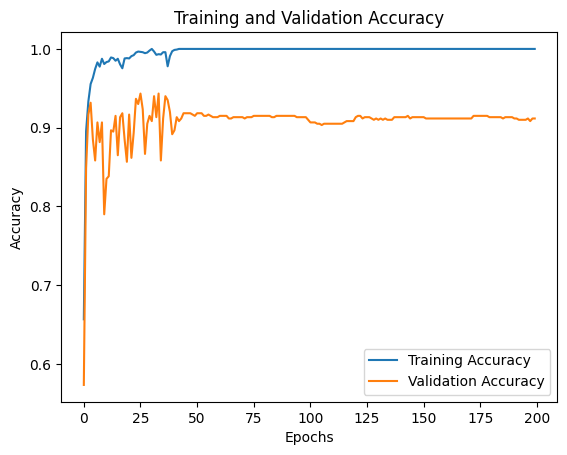

In [105]:

# Plot training and validation accuracy over epochs
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


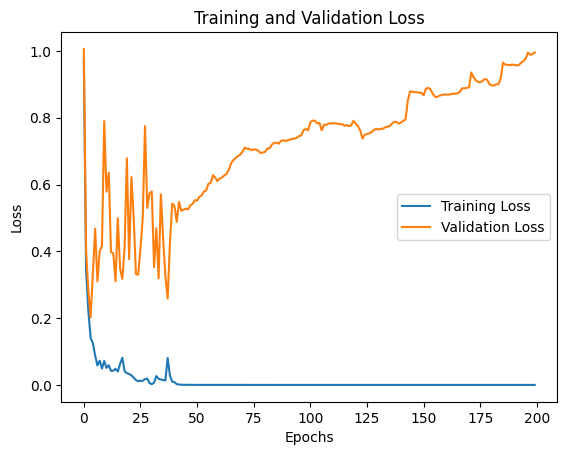

In [106]:
# Plot training and validation loss over epochs
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Prediction

In [107]:
def predict_sound(model, filename):
    #this reshapes the data and fit to the prediction model as new audio data.
    try:
        # Suppress UserWarning from librosa
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            # Extract features for the new sound file
            new_audio_data = extract_features(filename)
            print("Extracted features:", new_audio_data)

        if new_audio_data is not None: 
            # Reshape the data to match the model input shape
            new_audio_data = np.expand_dims(new_audio_data, axis=0)
            new_audio_data = np.expand_dims(new_audio_data, axis=-1)
            # Make predictions
            predictions = model.predict(new_audio_data)
            print("Predictions:", predictions)
            # Get the predicted class (index with the highest probability)
            predicted_class = np.argmax(predictions)
            print("Predicted Class:", predicted_class)
            # Map the predicted class to a label
            class_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'Pleasant Surprise', 'Sad']
            predicted_label = class_labels[predicted_class]

            return predicted_label
        else:
            return "Error extracting features"

    except Exception as e:
        return f"Error predicting sound: {e}"
    
    

# Final Result

In [127]:
#Finalize result
Sound_tester = "WhatsApp Ptt 2024-01-14 at 12.24.30 AM.wav"
predicted_label = predict_sound(model, Sound_tester)
print("Predicted Label:", predicted_label)

Extracted features: [-2.54645325e+02  1.45675369e+02 -1.67530785e+01  3.81944084e+01
 -9.82955742e+00 -3.36175728e+01 -3.71456337e+00  1.92356339e+01
 -1.66621132e+01 -8.28026581e+00 -8.44459534e+00 -2.08358879e+01
 -3.67635942e+00 -6.47616673e+00  1.27175255e+01  6.54220200e+00
 -6.39505053e+00 -2.43110865e-01 -1.16341114e+01 -7.09680557e+00
 -1.07610397e+01 -6.55283165e+00  1.42712450e+00 -1.06724348e+01
 -7.15684128e+00 -5.80762529e+00 -1.39538646e+00 -2.85378623e+00
  6.25145864e+00  1.25923481e+01  5.54337692e+00  1.65338783e+01
  1.32765360e+01  6.66318035e+00  3.72614717e+00 -4.38655734e-01
 -4.87937832e+00 -4.43296003e+00 -3.09313202e+00 -3.91786695e+00]
1/1 [==============================] - 0s 57ms/step
Predictions: [[1.4507319e-04 2.6110521e-07 9.9984837e-01 1.3036829e-07 7.9070890e-07
  7.3608156e-08 5.2408341e-06]]
Predicted Class: 2
Predicted Label: fear


In [ ]:
#This code save the model file so it can be used on other codes(assessments)
import pickle
# Writing different model files to file
with open( 'AudioEmotionRecognizer.sav', 'wb') as f:
    pickle.dump(model,f)

In [129]:
import speech_recognition as sr
r = sr.Recognizer()

with sr.Microphone() as src:
    audio = r.listen(src)
    print("running")
    with open ('testaudio/aaa.wav', 'wb') as f:
        f.write(audio.get_wav_data())

filename = 'AudioEmotionRecognizer.sav'
loaded_model = pickle.load(open(filename, 'rb')) # loading the model file from the storage
feature=predict_sound(loaded_model, "testaudio/aaa.wav")
print("Predicted Label:", feature)

running
Extracted features: [-7.0500928e+02  4.8671391e+01 -1.8221840e+01  2.3807789e+01
  2.1381739e+01  5.5849028e-01 -1.2913293e+00  9.6056855e-01
  7.1894157e-01  8.8360853e+00  8.5579205e+00  4.6758690e+00
 -1.9376011e+00 -6.3013798e-01 -4.9571857e-01  8.5122728e+00
  4.2146453e-01 -3.6159616e+00 -4.1351094e+00  5.5241756e+00
 -1.0843856e+00  3.3537402e+00  1.3561969e+00  5.1621828e+00
 -4.4888778e+00  2.5285327e+00  1.1793001e+00  5.6469131e-02
 -4.7998638e+00  3.5058777e+00  2.4366349e-01  2.7543490e+00
 -3.2371268e+00  3.0097232e+00 -3.5036838e-01  2.6768379e+00
  5.1976061e-01  6.6295953e+00 -3.6736872e+00  6.9021338e-01]
1/1 [==============================] - 1s 632ms/step
Predictions: [[6.9133769e-04 9.9054539e-01 8.4666382e-05 4.2522693e-04 1.2119470e-04
  2.1459861e-04 7.9176500e-03]]
Predicted Class: 1
Predicted Label: disgust
